# Deep Representation Learning

In this notebook, I provide the code for training and evaluating the only-Decoder model and the full Autoencoder model with the [STL-10](https://cs.stanford.edu/~acoates/stl10/) dataset.

# Imports and Functions

In [ ]:
import sys
import os
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive")

direc = '/content/drive/MyDrive/STL-10/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

### Data-related

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

class STL10_Dataset(torch.utils.data.Dataset):
    '''
    Commonly used class to get STL10 dataset.
    '''
    def __init__(self):
        super(STL10_Dataset, self).__init__()
        self.data = torchvision.datasets.STL10(root='./data', split='unlabeled',
                                            download=True, transform=transform)
        self.nsample = len(self.data)

    def __getitem__(self, index):
        data, target = self.data[index]
        return data, index

    def __len__(self):
        return self.nsample

def find_matching_index(idx, a):
    '''
    This function is used in training when using a subset of the data.
    It matches the representation id to the subset id
    (which is still the original data id).
    '''
    return [np.where(idx == x)[0][0] for x in a]

### Model classes

In [ ]:
class DecoderModule(nn.Module):
    '''
    Decoder module starting from a channel x 1 x 1 tensor.
    Channel steps are defined by a defined basis called capacity.
    '''
    def __init__(self,c):
        super(DecoderModule, self).__init__()
        self.capacity = c

        self.cnn = nn.Sequential(
            # (256,1)
            nn.ConvTranspose2d(in_channels=c*4, out_channels=c*4, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(c*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=c*2, out_channels=c*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=c*2, out_channels=c*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=c, out_channels=c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=1, stride=1, padding=0),
            # (3,96,96)
            nn.Sigmoid()
            )

    def forward(self, x):
        x = self.cnn(x)
        return x

class Decoder(nn.Module):
    '''
    Decoder takes decoder model and only adds a step in which to make sure
    to have the input in the right format. This is needed when using the decoder
    only to reshape the 1D representation vector into a 3D tensor.
    '''
    def __init__(self,c):
        super(Decoder, self).__init__()
        self.capacity = c

        self.dec = DecoderModule(c=c)

    def forward(self, x):
        x = x.view(x.size(0), self.capacity*4, 1, 1)
        x = self.dec(x)
        return x

class EncoderModule(nn.Module):
    '''
    Inverse of DecoderModule.
    '''
    def __init__(self,c):
        super(EncoderModule, self).__init__()
        self.capacity = c
        self.cnn = nn.Sequential(
            # In: (3,96,96)
            nn.Conv2d(in_channels=3, out_channels=c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c, out_channels=c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c*2, out_channels=c*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c*2, out_channels=c*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=c*4, out_channels=c*4, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True))
            # Out: (256,1)

    def forward(self, x):
        x = self.cnn(x)
        return x

class AE(nn.Module):
    '''
    Autoencoder built from encoder module and decoder module
    '''
    def __init__(self,c):
        super(AE, self).__init__()

        self.capacity = c

        self.enc = EncoderModule(c=c)
        self.dec = DecoderModule(c=c)

    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return y


#### Parameters

In [ ]:
# check number of parameters in new architecture
capacity = 64
decoder = Decoder(c=capacity)
if torch.cuda.is_available():
    decoder.cuda()
from torchsummary import summary
summary(decoder, (1, capacity*4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         590,080
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7          [-1, 128, 12, 12]         262,272
       BatchNorm2d-8          [-1, 128, 12, 12]             256
              ReLU-9          [-1, 128, 12, 12]               0
  ConvTranspose2d-10          [-1, 128, 24, 24]         262,272
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
  ConvTranspose2d-13           [-1, 64, 48, 48]         131,136
      BatchNorm2d-14           [-1, 64,

In [ ]:
# check number of parameters in new architecture
capacity = 64
encoder = EncoderModule(c=capacity)
if torch.cuda.is_available():
    encoder.cuda()
from torchsummary import summary
summary(encoder, (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             256
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
            Conv2d-4           [-1, 64, 48, 48]          65,600
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
            Conv2d-7          [-1, 128, 24, 24]         131,200
       BatchNorm2d-8          [-1, 128, 24, 24]             256
              ReLU-9          [-1, 128, 24, 24]               0
           Conv2d-10          [-1, 128, 12, 12]         262,272
      BatchNorm2d-11          [-1, 128, 12, 12]             256
             ReLU-12          [-1, 128, 12, 12]               0
           Conv2d-13            [-1, 128, 6, 6]         262,272
      BatchNorm2d-14            [-1, 12

In [ ]:
# check number of parameters
capacity = 64
ae = AE(c=capacity)
if torch.cuda.is_available():
    ae.cuda()
from torchsummary import summary
summary(ae, (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             256
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
            Conv2d-4           [-1, 64, 48, 48]          65,600
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
            Conv2d-7          [-1, 128, 24, 24]         131,200
       BatchNorm2d-8          [-1, 128, 24, 24]             256
              ReLU-9          [-1, 128, 24, 24]               0
           Conv2d-10          [-1, 128, 12, 12]         262,272
      BatchNorm2d-11          [-1, 128, 12, 12]             256
             ReLU-12          [-1, 128, 12, 12]               0
           Conv2d-13            [-1, 128, 6, 6]         262,272
      BatchNorm2d-14            [-1, 12

#### RepresentationLayer

In [ ]:
class RepresentationLayer(torch.nn.Module):
    '''
    Implements a representation layer, that accumulates pytorch gradients.
    To update representation, the pytorch framework does not work well, so
    the module comes with it's own SGD update (self.update(lr,mom,...)).
    '''
    def __init__(self, nrep, nsample,
                    rep_activity=(1.,1.),      # Normal distribution mean and stddev
                    norm=True                  # Normalize representation
                ):
        super(RepresentationLayer, self).__init__()
        self.nrep=nrep
        self.nsample=nsample
        self.mean, self.stddev = rep_activity[0],rep_activity[1]
        self.norm = norm
        self.init_rep(rep_activity[0],rep_activity[1])
        self.dz = None

    def init_rep(self,mean,stddev):
        # Generate random activities
        self.z = torch.nn.Parameter(torch.normal(mean,stddev,size=(self.nsample,self.nrep), requires_grad=True))

    def clamp(self):
        with torch.no_grad():
            if self.norm:
                self.z.clamp_(min=0)
                norm = 1./self.z.mean()
                self.z.mul_(norm)
            else:
                self.z.clamp_(min=0)

    def zero_grad(self):
        if self.z.grad is not None:
            self.z.grad.detach_()
            self.z.grad.zero_()

    def fix(self):
        self.z.requires_grad = False

    def unfix(self):
        self.z.requires_grad = True

    def forward(self, idx):
        if idx is None:
            return self.z
        else:
            return self.z[idx]

    def __getitem__(self,index):
        return self.z[index]

    def update(self,idx,lr=0.001,mom=0.9,wd=None):
        device = self.z.device
        if self.dz is None:
            self.dz = torch.zeros(self.z.size()).to(device)
        with torch.no_grad():
            # Update z
            # dz(k,j) = sum_i grad(k,i) w(i,j) step(z(j))
            self.dz[idx] = self.dz[idx].mul(mom) - self.z.grad[idx].mul(lr)
            if wd is not None:
                self.dz[idx] -= wd*self.z[idx]
            self.z[idx] += self.dz[idx]

### Training

In [ ]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def count_params(model):
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return num_params

def trainAE(data,testdata,nepocs,model,optimizer,
                 input_dims,test_no,test_lc=True):

    nsample = data.dataset.__len__()
    nsample_test = testdata.dataset.__len__()

    # init decoder
    model=model.to(device)

    criterion = nn.MSELoss(reduction='sum')

    train_avg = []
    test_avg = []
    for epoch in range(nepocs):
        train_avg.append(0)
        num_batches = 0
        for x, i in data:
            optimizer.zero_grad()
            x = x.to(device)
            # compute reconstructions
            y = model(x)
            # compute loss
            loss = criterion(y,x)
            loss.backward()

            optimizer.step()

            train_avg[-1] += loss.item()
            num_batches += 1
        train_avg[-1] /= nsample*input_dims

        if test_lc:
            test_avg.append(0)
            num_batches = 0
            for x, i in testdata:
                i = i-test_no
                optimizer.zero_grad()
                x = x.to(device)
                y = model(x)
                # compute loss
                loss = criterion(y,x)
                loss.backward()

                test_avg[-1] += loss.item()
                num_batches += 1
            test_avg[-1] /= nsample_test*input_dims
        elif epoch == nepocs - 1:
            test_avg.append(0)
            num_batches = 0
            for x, i in testdata:
                i = i-test_no
                optimizer.zero_grad()
                x = x.to(device)
                y = model(x)
                # compute loss
                loss = criterion(y,x)
                loss.backward()

                test_avg[-1] += loss.item()
                num_batches += 1
            test_avg[-1] /= nsample_test*input_dims

    final_metrics = pd.DataFrame({'epoch': np.arange(nepocs),
                                    'loss': train_avg,
                                    'type': 'train'
                                    })
    if test_lc:
        final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),
                                                            'loss':test_avg,
                                                            'type': 'test'
                                                            }))
    else:
        final_metrics = final_metrics.append(pd.DataFrame({'epoch': nepocs-1,
                                                            'loss':test_avg,
                                                            'type': 'test'
                                                            }))
    return model, final_metrics, optimizer

def trainDecoder(data,testdata,nepocs,decoder,representation,test_representation,optimizer,
                 latent_dim,lr,lr_rep,test_no,input_dims,mom=0.95,
                 indices_images=None,indices_images_test=None):

    nsample = data.dataset.__len__()
    nsample_test = testdata.dataset.__len__()

    # optimizers
    decoder_optimizer = optimizer[0]
    representation_optimizer = optimizer[1]
    test_representation_optimizer = optimizer[2]

    criterion = nn.MSELoss(reduction='sum')

    train_avg = []
    test_avg = []
    for epoch in range(nepocs):
        train_avg.append(0)
        num_batches = 0

        representation.zero_grad()
        for x, i in data:
            decoder_optimizer.zero_grad()
            x = x.to(device)

            # compute reconstructions
            if indices_images != None:
                pos = find_matching_index(indices_images,i.numpy())
                z = representation(pos)
            else:
                z = representation(i)
            y = decoder(z)

            # compute loss
            loss = criterion(y,x)
            loss.backward()

            if indices_images != None:
                representation.update(pos,lr=lr_rep,mom=mom)
            else:
                representation.update(i,lr=lr_rep,mom=mom)
            decoder_optimizer.step()

            train_avg[-1] += loss.item()
            num_batches += 1
            train_avg[-1] /= nsample*input_dims

            num_batches = 0
            test_representation.zero_grad()
            test_avg.append(0)
    for x, i in testdata:
        i = i-test_no
        decoder_optimizer.zero_grad()
        x = x.to(device)
        # compute reconstructions
        if indices_images_test != None:
            pos = find_matching_index(indices_images_test,i.numpy())
            z = test_representation(pos)
        else:
            z = test_representation(i)
        y = decoder(z)

        # compute loss
        loss = criterion(y,x)
        loss.backward()

        if indices_images_test != None:
            test_representation.update(pos,lr=lr_rep,mom=mom)
        else:
            test_representation.update(i,lr=lr_rep,mom=mom)

        test_avg[-1] += loss.item()
        num_batches += 1
        test_avg[-1] /= nsample_test*input_dims

    final_metrics = pd.DataFrame({'epoch': np.arange(nepocs),
                                'loss': train_avg,
                                'type': 'train'
                                })
    final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),
                                                        'loss':test_avg,
                                                        'type': 'test'
                                                        }))
    optimizer = []
    optimizer.append(decoder_optimizer)
    optimizer.append(representation_optimizer)
    optimizer.append(test_representation_optimizer)
    return decoder, representation, test_representation, final_metrics, optimizer


### Visualization

In [ ]:
# Visualization of models progress while training

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img, a=None):
    img = to_img(img)
    npimg = img.numpy()
    if a is not None:
        a.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def rep_recon_plot_ae(train_set, test_set, model, test_no, data_type='full'):

    fig, ax = plt.subplots(figsize=(20,5), ncols=4)

    with torch.no_grad():
        img_recon = []
        test_img_recon = []
        images_list = []
        images_test_list = []
        for i in range(16):
            if data_type == 'subset':
                img_recon.append(model(train_set.dataset.data[i][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())
                test_img_recon.append(model(test_set.dataset.data[i+test_no][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())
                images_list.append(train_set.dataset.data[i][0])
                images_test_list.append(test_set.dataset.data[i+test_no][0])
            else:
                img_recon.append(model(train_set.data[i][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())
                test_img_recon.append(model(test_set.data[i][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu())
                images_list.append(train_set.data[i][0])
                images_test_list.append(test_set.data[i][0])

    ax[0].set_title('reconstructed train images')
    show_image(torchvision.utils.make_grid(img_recon,4,4),a=ax[0])
    ax[1].set_title('original train images')
    show_image(torchvision.utils.make_grid(images_list,4,4),a=ax[1])

    ax[2].set_title('reconstructed test images')
    show_image(torchvision.utils.make_grid(test_img_recon,4,4),a=ax[2])
    ax[3].set_title('original test images')
    show_image(torchvision.utils.make_grid(images_test_list,4,4),a=ax[3])
    plt.show()

def rep_recon_plot_decoder(train_set, test_set, decoder, rep, test_rep, test_no, data_type='full'):

    fig, ax = plt.subplots(figsize=(20,5), ncols=4)

    with torch.no_grad():
        # reconstruct images from the representation
        img_recon = decoder(rep.z[:16,:]).detach().cpu()
        test_img_recon = decoder(test_rep.z[:16,:]).detach().cpu()

    images_list = []
    images_test_list = []
    for i in range(16):
        if data_type == 'subset':
            images_list.append(train_set.dataset.data[i][0])
            images_test_list.append(test_set.dataset.data[i+test_no][0])
        else:
            images_list.append(train_set.data[i][0])
            images_test_list.append(test_set.data[i][0])

    ax[0].set_title('reconstructed train images')
    show_image(torchvision.utils.make_grid(img_recon.data[:16],4,4),a=ax[0])
    ax[1].set_title('original train images')
    show_image(torchvision.utils.make_grid(images_list,4,4),a=ax[1])

    ax[2].set_title('reconstructed test images')
    show_image(torchvision.utils.make_grid(test_img_recon.data[:16],4,4),a=ax[2])
    ax[3].set_title('original test images')
    show_image(torchvision.utils.make_grid(images_test_list,4,4),a=ax[3])
    plt.show()

def load_states(list_input_dirs, model_type='basic'):
    if len(list_input_dirs) > 1:
        decoder = Decoder(c=64)
        checkpoint = torch.load(list_input_dirs[0], map_location=device)
        decoder.load_state_dict(checkpoint)
        test_representation = RepresentationLayer(64*4,10000)
        checkpoint = torch.load(list_input_dirs[1], map_location=device)
        test_representation.load_state_dict(checkpoint)
        return decoder, test_representation
    else:
        autoencoder = AE(c=64)
        checkpoint = torch.load(list_input_dirs[0], map_location=device)
        autoencoder.load_state_dict(checkpoint)
        return autoencoder

# Training Decoder and AE

Train and test both models on the dataset for 400 epochs, saving the model parameters every 50 epochs in order to achieve a visual comparison alongside the learning curves.

In [ ]:
#########################
# global parameters #
#########################

input_dims = 96*96*3
lr_decoder = 1e-4
lr_rep = 1e-1
wd = 1e-5
capacity = 64
n_epochs = 100
TEST_NO = 50_001

random_seeds = [0,142,2358,7,8973]
sample_steps = [100,50,10,1]
batch_sizes = [32,64,128,256]

# load data
dataset = STL10_Dataset()
trainset = torch.utils.data.Subset(dataset, range(TEST_NO))
testset = torch.utils.data.Subset(dataset, range(TEST_NO, TEST_NO+10_000))

Files already downloaded and verified


## Decoder

<ipython-input-5-9d43e097689d>:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),


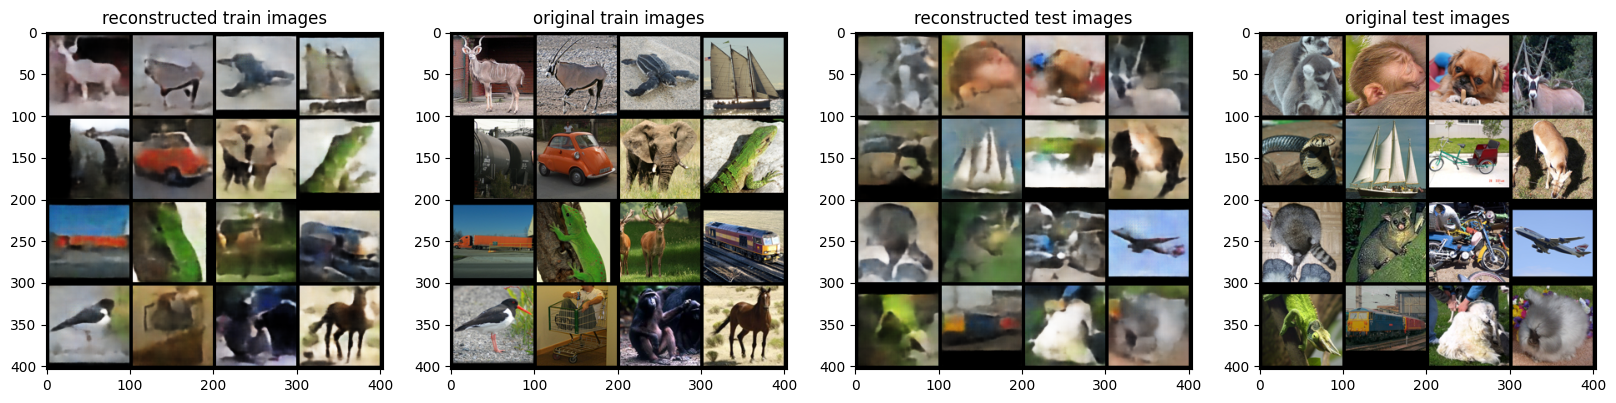

<ipython-input-5-9d43e097689d>:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),


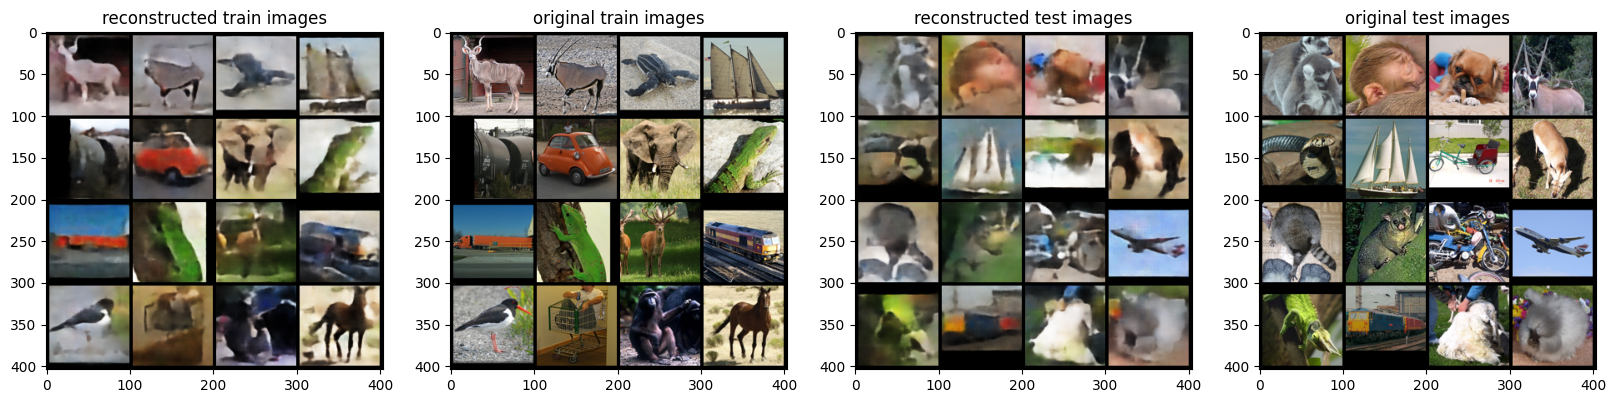

KeyboardInterrupt: ignored

In [ ]:
resume = True

repeat = 0
random_seed = random_seeds[repeat]
set_random_seed(random_seed)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                          shuffle=True, num_workers=2)

decoder = Decoder(c=capacity).to(device)
representation = RepresentationLayer(capacity*4,trainset.__len__()).to(device)
test_representation = RepresentationLayer(capacity*4,testset.__len__()).to(device)
optimizer = [torch.optim.Adam(decoder.parameters(), lr=lr_decoder, weight_decay=wd)]
optimizer.append(torch.optim.Adam(representation.parameters(), lr=lr_rep))
optimizer.append(torch.optim.Adam(test_representation.parameters(), lr=lr_rep))

if resume:
    checkpoint = torch.load(direc+'STL_300epochs_v2.pt')
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    representation.load_state_dict(checkpoint['rep_state_dict'])
    test_representation.load_state_dict(checkpoint['testrep_state_dict'])
    optimizer[0].load_state_dict(checkpoint['decoder_optimizer'])
    optimizer[1].load_state_dict(checkpoint['representation_optimizer'])
    optimizer[2].load_state_dict(checkpoint['test_representation_optimizer'])

n_epochs = 50
for i in range(8):
    decoder, representation, test_representation, history, optimizer = trainDecoder(trainloader, testloader,
                                                                        nepocs=n_epochs, decoder=decoder,
                                                                        representation=representation,
                                                                        test_representation=test_representation,
                                                                        optimizer=optimizer,
                                                                        latent_dim=capacity*4,lr=lr_decoder, lr_rep=lr_rep,
                                                                        test_no=TEST_NO,
                                                                        input_dims=input_dims, mom=0.9,
                                                                        indices_images=None, indices_images_test=None)
    torch.save({
                'decoder_state_dict': decoder.state_dict(),
                'rep_state_dict': representation.state_dict(),
                'testrep_state_dict': test_representation.state_dict(),
                'decoder_optimizer': optimizer[0].state_dict(),
                'representation_optimizer': optimizer[1].state_dict(),
                'test_representation_optimizer': optimizer[2].state_dict()
                }, direc+'STL_'+str(n_epochs*(i+1))+'epochs.pt')

    rep_recon_plot_decoder(train_set=trainset,
                            test_set=testset,
                            decoder=decoder,
                            rep=representation,
                            test_rep=test_representation,
                            test_no=TEST_NO,
                            data_type='subset')
    if i == 0:
        history.to_csv(direc+'STL_decoder_fig2_history.csv', index=False)
    else:
        history['epoch'] = history['epoch'].values + (i*50)
        history.to_csv(direc+'STL_decoder_fig2_history.csv', mode='a', index=False, header=False)

## AE

<ipython-input-5-a5913c8967e9>:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_metrics = final_metrics.append(pd.DataFrame({'epoch': np.arange(nepocs),


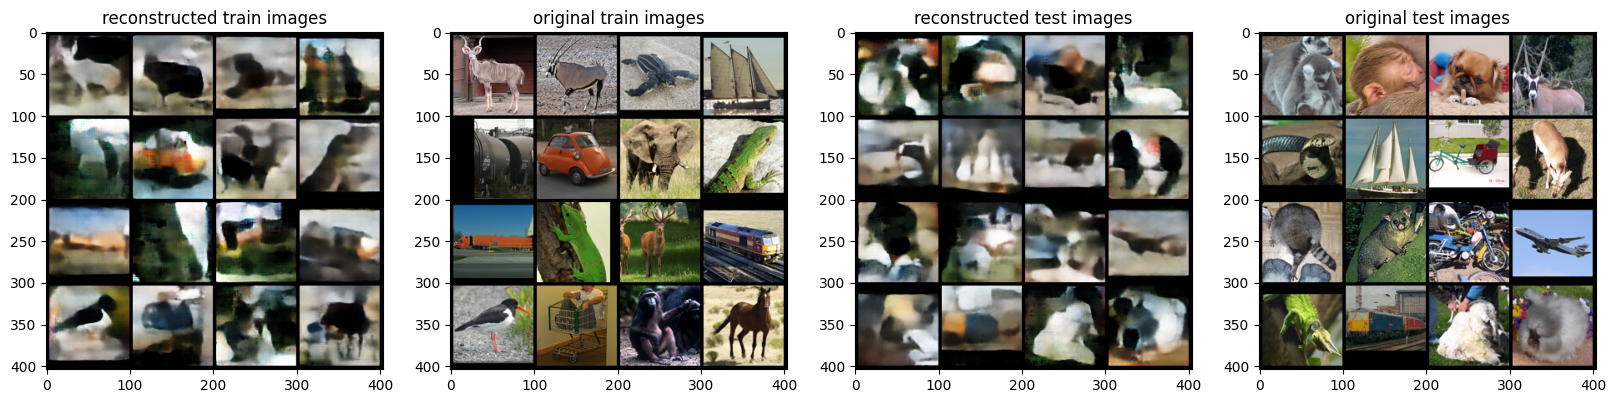

In [ ]:
resume = True

lr = 1e-4
repeat = 0
random_seed = random_seeds[repeat]
set_random_seed(random_seed)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                          shuffle=True, num_workers=2)

autoencoder = AE(c=capacity).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=wd)

if resume:
    checkpoint = torch.load(direc+'STL_autoencoder350epochs.pt')
    autoencoder.load_state_dict(checkpoint['autoencoder_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

n_epochs = 50
for i in range(7,8):
    autoencoder, history, optimizer = trainAE(trainloader,
                                              testloader,
                                              nepocs=n_epochs,
                                              model=autoencoder,
                                              optimizer=optimizer,
                                              test_no=TEST_NO,
                                              input_dims=input_dims,
                                              test_lc=True)
    torch.save({'autoencoder_state_dict': autoencoder.state_dict(),
                'optimizer': optimizer.state_dict(),
                }, direc+'STL_autoencoder'+str(n_epochs*(i+1))+'epochs.pt')

    rep_recon_plot_ae(train_set=trainset,
                      test_set=testset,
                      model=autoencoder,
                      test_no=TEST_NO,
                      data_type='subset')
    if i == 0:
        history.to_csv(direc+'STL_autoencoder_fig2_history.csv', index=False)
    else:
        history['epoch'] = history['epoch'].values + (i*50)
        history.to_csv(direc+'STL_autoencoder_fig2_history.csv', mode='a', index=False, header=False)

# Plots

In [ ]:
history_ae = pd.read_csv(direc+'STL_autoencoder_fig2_history.csv')
history_ae['model'] = 'AE'
history_test = history_ae
history_decoder = pd.read_csv(direc+'STL_decoder_fig2_history.csv')
history_decoder['model'] = 'decoder'
history_test = history_test.append(history_decoder)

history_test = history_test[history_test['type']=='test']

<ipython-input-8-a135c1781548>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_test = history_test.append(history_decoder)


In [ ]:
import copy

stops = [50,200,400]

decoder_list = []
test_rep_list = []
ae_list = []
temp_ae = AE(c=capacity).to(device)
temp_decoder = Decoder(c=capacity).to(device)
temp_test_rep = RepresentationLayer(capacity*4,testset.__len__()).to(device)
for i in stops:
    checkpoint_dec = torch.load(direc+'STL_decoder_'+str(i)+'epochs.pt')
    temp_decoder.load_state_dict(checkpoint_dec['decoder_state_dict'])
    temp_test_rep.load_state_dict(checkpoint_dec['testrep_state_dict'])
    decoder_list.append(copy.deepcopy(temp_decoder))
    test_rep_list.append(copy.deepcopy(temp_test_rep))

    checkpoint_ae = torch.load(direc+'STL_autoencoder'+str(i)+'epochs.pt')
    temp_ae.load_state_dict(checkpoint_ae['autoencoder_state_dict'])
    ae_list.append(copy.deepcopy(temp_ae))


In [ ]:
def rep_recon_plot_mixed(test_set, decoder_list, test_rep_list, ae_list, epoch_list, annot_labels, fs=14):

    fig, ax = plt.subplots(figsize=(14,10), ncols=7)

    for i in range(len(decoder_list)):
        decoder = decoder_list[i]
        test_rep = test_rep_list[i]

        ae_img_recon = torch.zeros((8,3,96,96))
        with torch.no_grad():
            # reconstruct images from the representation
            test_img_recon = decoder(test_rep.z[:8,:]).detach().cpu()
            for k in range(8):
                ae_img_recon[k,:,:,:] = ae_list[i](test_set.dataset.data[k+TEST_NO][0].unsqueeze(0).to(device)).squeeze(0).detach().cpu()

        ax[i].set_title(str(epoch_list[i]))
        show_image(torchvision.utils.make_grid(test_img_recon.data[:8],2,4),a=ax[i])

        ax[i+3].set_title(str(epoch_list[i]))
        show_image(torchvision.utils.make_grid(ae_img_recon,2,4),a=ax[i+3])

        ax[i].xaxis.set_visible(False)
        ax[i].yaxis.set_visible(False)
        ax[i+3].xaxis.set_visible(False)
        ax[i+3].yaxis.set_visible(False)

    ax[1].annotate(annot_labels[0], xy=(0.5, 1.2), xycoords='axes fraction',
                 va='center', ha='center',fontsize=fs)
    ax[4].annotate(annot_labels[1], xy=(0.5, 1.2), xycoords='axes fraction',
                 va='center', ha='center',fontsize=fs)

    images_test_list = []
    for j in range(8):
        images_test_list.append(testset.dataset.data[j+TEST_NO][0])
    ax[6].set_title('')
    show_image(torchvision.utils.make_grid(images_test_list,2,4),a=ax[6])
    ax[6].xaxis.set_visible(False)
    ax[6].yaxis.set_visible(False)
    ax[6].annotate(annot_labels[2], xy=(0.5, 1.2), xycoords='axes fraction',
                 va='center', ha='center',fontsize=fs)

    plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 10})
my_colors = ['#8ecae6', '#219ebc', '#023047', '#ffb703', '#fb8500']

<ipython-input-41-96a00e0d94f4>:34: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data=history_test, x='epoch', y='loss', hue='model',


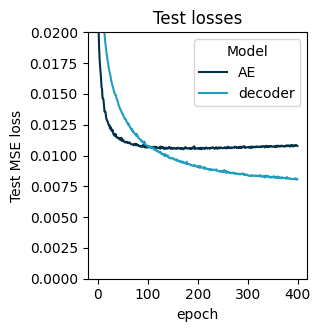

In [ ]:
total_rows = 2
total_columns = 10

fig = plt.figure(figsize=(12,8))

anno_opts = dict(xycoords='axes fraction',
                 va='center', ha='center',fontsize=14)

ax4 = plt.subplot2grid((total_rows,total_columns), (0,7), colspan=3)
sns.lineplot(data=history_test, x='epoch', y='loss', hue='model',
             palette=sns.color_palette(['#023047', '#219ebc', '#C1554E', '#ffb703']),
             ax=ax4)
ax4.set_title('Test losses')
ax4.set_ylabel('Test MSE loss')
ax4.set_ylim((0,0.02))
ax4.legend(title='Model')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=0.5)
plt.show()

<ipython-input-21-fae545ee48c5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history_train = history_train.append(history_decoder)
<ipython-input-21-fae545ee48c5>:21: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data=history_train, x='epoch', y='loss', hue='model',


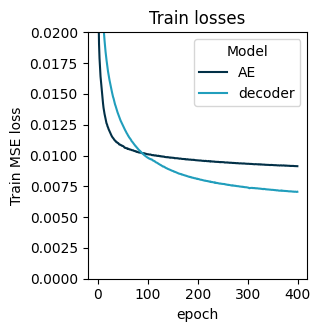

In [ ]:
history_ae = pd.read_csv(direc+'STL_autoencoder_fig2_history.csv')
history_ae['model'] = 'AE'
history_train = history_ae
history_decoder = pd.read_csv(direc+'STL_decoder_fig2_history.csv')
history_decoder['model'] = 'decoder'
history_train = history_train.append(history_decoder)

history_train = history_train[history_train['type']=='train']
total_rows = 2
total_columns = 10

fig = plt.figure(figsize=(12,8))

anno_opts = dict(xycoords='axes fraction',
                 va='center', ha='center',fontsize=14)

ax4 = plt.subplot2grid((total_rows,total_columns), (0,7), colspan=3)
sns.lineplot(data=history_train, x='epoch', y='loss', hue='model',
             palette=sns.color_palette(['#023047', '#219ebc', '#C1554E', '#ffb703']),
             ax=ax4)
ax4.set_title('Train losses')
ax4.set_ylabel('Train MSE loss')
ax4.set_ylim((0,0.02))
ax4.legend(title='Model')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=0.5)
plt.show()

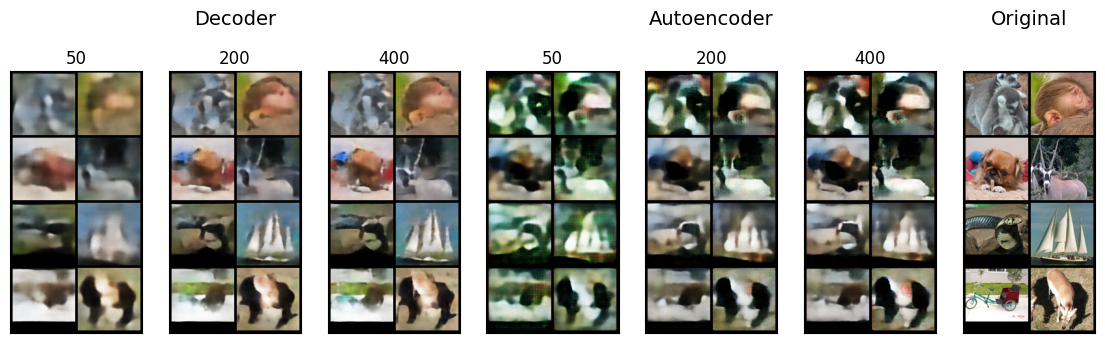

In [ ]:
rep_recon_plot_mixed(testset, decoder_list, test_rep_list, ae_list, stops, annot_labels=['Decoder','Autoencoder','Original'])